# Experimental Design
***
## Kinetics

Import the necessary packages and code to generate the kinetics results.

In [1]:
%matplotlib inline

import numpy as np
import os, sys
# Add to system path to access experimental design code.
sys.path.append('../experimental-design')
sys.path.append('../experimental-design/models')

from scipy.optimize import differential_evolution

from monolayers import MonolayerDPPG
from utils import save_plot

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 100

Define the 1,2-dipalmitoyl-sn-glycero-3-phospho-(1-rac-glycerol) (DPPG) monolayer model and get the fitted SLD profile (without and with protein) and reflectivity curve for the experimentally-measured (protein-bound) data sets.

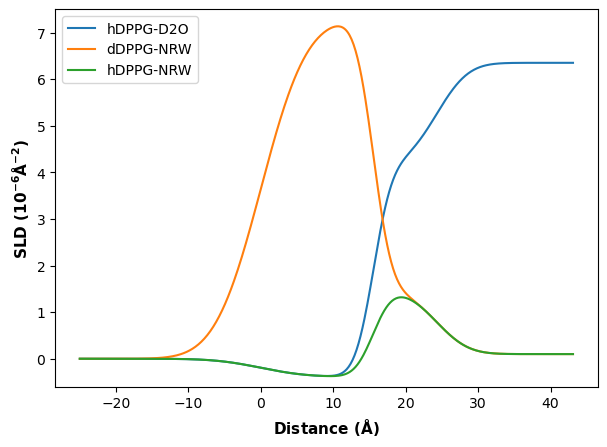

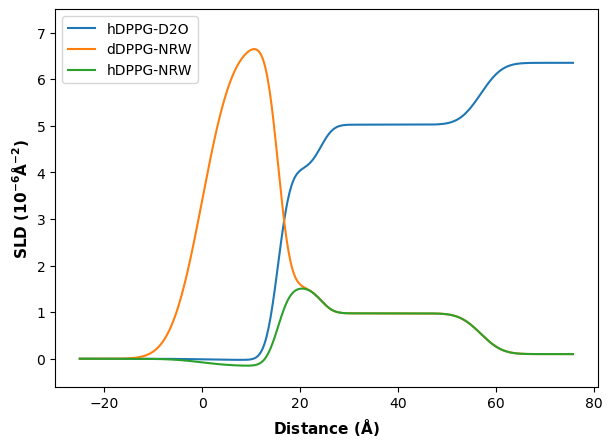

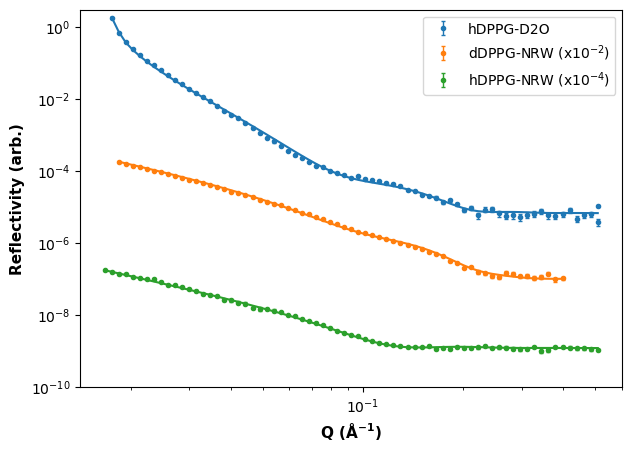

In [2]:
dppg_monolayer = MonolayerDPPG()

save_path = './results'
dppg_monolayer.sld_profile(save_path)
dppg_monolayer.reflectivity_profile(save_path)

Get the plots of Fisher information in the lipid APM versus contrast SLD and measurement angle for the h-DPPG and d-DPPG monolayer models. To account for the sample degradation, data is simulated for 20 lipid APM values, ranging from the fitted value of 54.1Å<sup>2</sup> to 500Å<sup>2</sup>, with the FI calculated over the entire simulated data set; this quantifies the maximum information obtainable about the APM over the full experiment using the given conditions. 

>>> 0/625
>>> 125/625
>>> 250/625
>>> 375/625
>>> 500/625
>>> 0/625
>>> 125/625
>>> 250/625
>>> 375/625
>>> 500/625


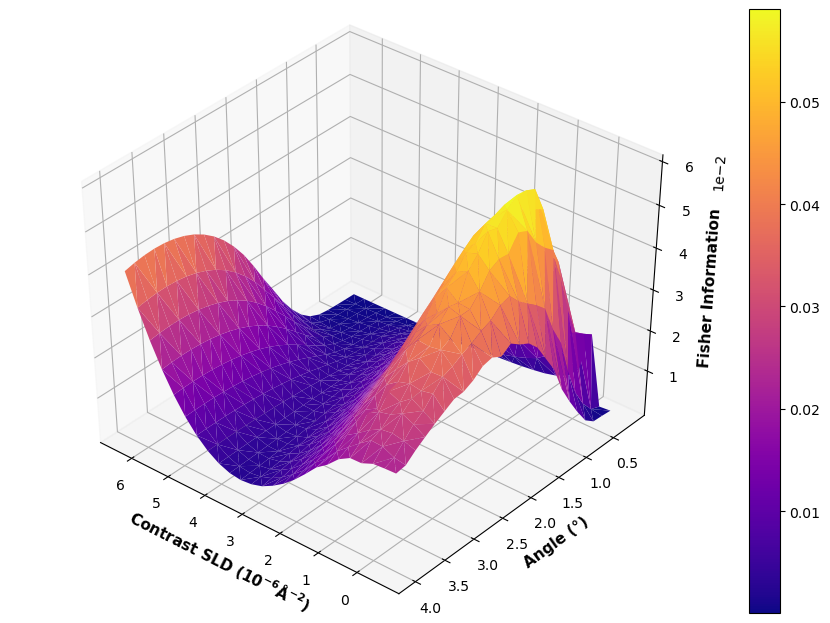

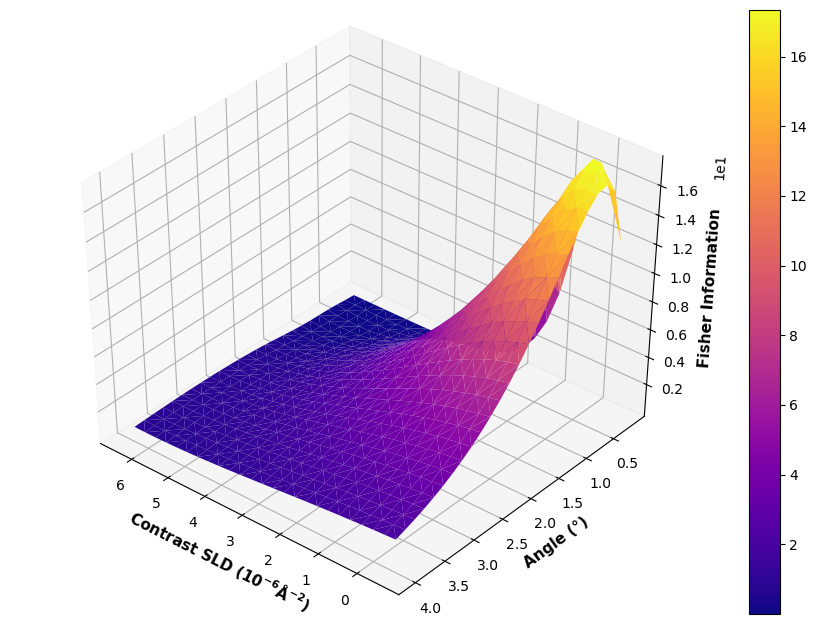

In [3]:
def angle_contrast_choice(deuterated, save_path):
    monolayer = MonolayerDPPG(deuterated=deuterated)

    # Angles, contrasts and lipid area per molecule values to consider.
    angle_range = np.linspace(0.2, 4.0, 25)
    contrast_range = np.linspace(-0.56, 6.36, 25)
    apm_range = np.linspace(54.1039, 500, 20)

    # Number of points and measurement time to use when simulating data.
    points = 100
    time = 100

    # Iterate over each contrast and angle being considered.
    x, y, infos = [], [], []
    n = len(angle_range)*len(contrast_range) # Number of calculations.
    for i, contrast_sld in enumerate(contrast_range):
        # Display progress.
        if i % 5 == 0:
            print('>>> {0}/{1}'.format(i*len(angle_range), n))

        for angle in angle_range:
            # Record the "true" lipid APM value.
            apm = monolayer.lipid_apm.value

            # Split the time budget based on number of APM values.
            angle_times = [(angle, points, time/len(apm_range))]

            # Calculate the lipid APM Fisher information for each value.
            information = 0
            for new_apm in apm_range:
                # Use the new APM value, corresponding to a degrading sample.
                monolayer.lipid_apm.value = new_apm
                g = monolayer.contrast_info(angle_times, [contrast_sld])
                information += g[0, 0]

            monolayer.lipid_apm.value = apm # Reset the APM parameter.
            infos.append(information)
            x.append(contrast_sld)
            y.append(angle)

    # Create the plot of angle and contrast SLD versus Fisher information.
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111, projection='3d')

    # Create the surface plot and add colour bar.
    surface = ax.plot_trisurf(x, y, infos, cmap='plasma')
    fig.colorbar(surface, fraction=0.046, pad=0.04)

    # Adjust the viewing angle of the 3D plot.
    ax.view_init(elev=40, azim=130)

    ax.set_xlabel('$\mathregular{Contrast\ SLD\ (10^{-6} \AA^{-2})}$', fontsize=11, weight='bold')
    ax.set_ylabel('Angle (°)', fontsize=11, weight='bold')
    ax.set_zlabel('Fisher Information', fontsize=11, weight='bold')
    ax.ticklabel_format(axis='z', style='sci', scilimits=(0,0))

    # Save the plot.
    save_path = os.path.join(save_path, monolayer.name)
    tg_type = 'deuterated' if deuterated else 'hydrogenated'
    filename = 'angle_contrast_choice_' + tg_type
    save_plot(fig, save_path, filename)

angle_contrast_choice(False, save_path)
angle_contrast_choice(True, save_path)